In [2]:
import keras
import keras.utils
from keras import utils as np_utils

import tensorflow.keras.layers
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import cv2
import numpy as np

In [18]:
#from keras import backend as K
import tensorflow.keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-dataset/gaussian_filtered_images',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-dataset/gaussian_filtered_images', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
    ) # set as validation data

input_img = Input(shape=(224, 224, 3))

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [10]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam

#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications
from keras.applications import densenet

DENSENET_121 = Sequential()

densenet121_model = keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3), pooling='max', classes=5
)

In [20]:
import logging
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback
import os

# Setup logging
log_file = "DENSENET121_Training.log"
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', handlers=[logging.FileHandler(log_file), logging.StreamHandler()])

class LoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logging.info(f"Epoch {epoch + 1}: {logs}")

# Load DenseNet-121 model without top layers
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
DENSENET_121 = Sequential()

# Set layers in densenet121_model to non-trainable
for layer in densenet121_model.layers:
    layer.trainable = False

# Add layers to the model
DENSENET_121.add(densenet121_model)
DENSENET_121.add(Flatten())
DENSENET_121.add(Dropout(0.2))
DENSENET_121.add(Dense(1024, activation='relu'))
DENSENET_121.add(Dropout(0.2))
DENSENET_121.add(Dense(512, activation='relu'))
DENSENET_121.add(Dense(5, activation='softmax'))

# Summary of the model
#DENSENET_121.summary()

# Compile the model
adam = Adam(learning_rate=0.001)
DENSENET_121.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# Train the model
graph = DENSENET_121.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[LoggingCallback()])

# Save the model
DENSENET_121.save("/Users/hardikchhipa/Desktop/DR-dataset/saved models")

# Print the results
print(graph.history)


Epoch 1/25


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5454 - f1_m: 0.5436 - loss: 11.4938 - precision_m: 0.5540 - recall_m: 0.5346

2024-07-19 15:16:26,051 Epoch 1: {'accuracy': 0.6233367323875427, 'f1_m': 0.622532308101654, 'loss': 4.709865093231201, 'precision_m': 0.6398889422416687, 'recall_m': 0.6071760654449463, 'val_accuracy': 0.7318741679191589, 'val_f1_m': 0.7283778190612793, 'val_loss': 0.7393386363983154, 'val_precision_m': 0.8278528451919556, 'val_recall_m': 0.6517713665962219}


92/92 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.5462 - f1_m: 0.5444 - loss: 11.4208 - precision_m: 0.5550 - recall_m: 0.5354 - val_accuracy: 0.7319 - val_f1_m: 0.7284 - val_loss: 0.7393 - val_precision_m: 0.8279 - val_recall_m: 0.6518
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7347 - f1_m: 0.7286 - loss: 0.7882 - precision_m: 0.7842 - recall_m: 0.6820

2024-07-19 15:21:14,587 Epoch 2: {'accuracy': 0.7301262617111206, 'f1_m': 0.7229963541030884, 'loss': 0.7999352216720581, 'precision_m': 0.7784069180488586, 'recall_m': 0.6783645749092102, 'val_accuracy': 0.730506181716919, 'val_f1_m': 0.7333419919013977, 'val_loss': 0.7626722455024719, 'val_precision_m': 0.7673124074935913, 'val_recall_m': 0.7035024166107178}


92/92 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.7346 - f1_m: 0.7286 - loss: 0.7883 - precision_m: 0.7841 - recall_m: 0.6819 - val_accuracy: 0.7305 - val_f1_m: 0.7333 - val_loss: 0.7627 - val_precision_m: 0.7673 - val_recall_m: 0.7035
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7100 - f1_m: 0.6991 - loss: 0.8365 - precision_m: 0.7614 - recall_m: 0.6488

2024-07-19 15:25:59,599 Epoch 3: {'accuracy': 0.7270556092262268, 'f1_m': 0.7174690365791321, 'loss': 0.7844168543815613, 'precision_m': 0.7812279462814331, 'recall_m': 0.6661720871925354, 'val_accuracy': 0.7400820851325989, 'val_f1_m': 0.7345167398452759, 'val_loss': 0.6746105551719666, 'val_precision_m': 0.8695175051689148, 'val_recall_m': 0.6401469111442566}


92/92 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.7102 - f1_m: 0.6993 - loss: 0.8359 - precision_m: 0.7616 - recall_m: 0.6490 - val_accuracy: 0.7401 - val_f1_m: 0.7345 - val_loss: 0.6746 - val_precision_m: 0.8695 - val_recall_m: 0.6401
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7359 - f1_m: 0.7343 - loss: 0.6904 - precision_m: 0.8259 - recall_m: 0.6649

2024-07-19 15:31:02,149 Epoch 4: {'accuracy': 0.7407028079032898, 'f1_m': 0.7328453660011292, 'loss': 0.6979737877845764, 'precision_m': 0.8150924444198608, 'recall_m': 0.6694436073303223, 'val_accuracy': 0.7756497859954834, 'val_f1_m': 0.7590804696083069, 'val_loss': 0.6257868409156799, 'val_precision_m': 0.8578272461891174, 'val_recall_m': 0.6826187372207642}


92/92 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.7360 - f1_m: 0.7343 - loss: 0.6905 - precision_m: 0.8258 - recall_m: 0.6649 - val_accuracy: 0.7756 - val_f1_m: 0.7591 - val_loss: 0.6258 - val_precision_m: 0.8578 - val_recall_m: 0.6826
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7434 - f1_m: 0.7435 - loss: 0.6750 - precision_m: 0.8334 - recall_m: 0.6743

2024-07-19 15:36:08,766 Epoch 5: {'accuracy': 0.7553735971450806, 'f1_m': 0.7492935061454773, 'loss': 0.6679997444152832, 'precision_m': 0.8363012075424194, 'recall_m': 0.6823691725730896, 'val_accuracy': 0.7688098549842834, 'val_f1_m': 0.7649659514427185, 'val_loss': 0.6345553398132324, 'val_precision_m': 0.8304443955421448, 'val_recall_m': 0.7107990980148315}


92/92 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.7435 - f1_m: 0.7436 - loss: 0.6750 - precision_m: 0.8335 - recall_m: 0.6744 - val_accuracy: 0.7688 - val_f1_m: 0.7650 - val_loss: 0.6346 - val_precision_m: 0.8304 - val_recall_m: 0.7108
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7458 - f1_m: 0.7386 - loss: 0.6753 - precision_m: 0.8463 - recall_m: 0.6594

2024-07-19 15:41:13,833 Epoch 6: {'accuracy': 0.7540088891983032, 'f1_m': 0.7469770908355713, 'loss': 0.6580697298049927, 'precision_m': 0.8479452729225159, 'recall_m': 0.6719644069671631, 'val_accuracy': 0.7742817997932434, 'val_f1_m': 0.7691397666931152, 'val_loss': 0.6325188279151917, 'val_precision_m': 0.827516496181488, 'val_recall_m': 0.7202093601226807}


92/92 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.7458 - f1_m: 0.7387 - loss: 0.6751 - precision_m: 0.8464 - recall_m: 0.6595 - val_accuracy: 0.7743 - val_f1_m: 0.7691 - val_loss: 0.6325 - val_precision_m: 0.8275 - val_recall_m: 0.7202
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7509 - f1_m: 0.7475 - loss: 0.6542 - precision_m: 0.8344 - recall_m: 0.6807

2024-07-19 15:46:23,515 Epoch 7: {'accuracy': 0.7581030130386353, 'f1_m': 0.7493038773536682, 'loss': 0.6478817462921143, 'precision_m': 0.848127007484436, 'recall_m': 0.675468385219574, 'val_accuracy': 0.7688098549842834, 'val_f1_m': 0.772341787815094, 'val_loss': 0.6142221093177795, 'val_precision_m': 0.8508514165878296, 'val_recall_m': 0.7088364958763123}


92/92 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.7510 - f1_m: 0.7476 - loss: 0.6541 - precision_m: 0.8346 - recall_m: 0.6807 - val_accuracy: 0.7688 - val_f1_m: 0.7723 - val_loss: 0.6142 - val_precision_m: 0.8509 - val_recall_m: 0.7088
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7745 - f1_m: 0.7681 - loss: 0.5890 - precision_m: 0.8575 - recall_m: 0.6993

2024-07-19 15:51:37,118 Epoch 8: {'accuracy': 0.7645854949951172, 'f1_m': 0.7612144351005554, 'loss': 0.6171518564224243, 'precision_m': 0.8538550734519958, 'recall_m': 0.6900743842124939, 'val_accuracy': 0.7715458273887634, 'val_f1_m': 0.7700303196907043, 'val_loss': 0.6591677665710449, 'val_precision_m': 0.8533993363380432, 'val_recall_m': 0.7031501531600952}


92/92 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7744 - f1_m: 0.7680 - loss: 0.5893 - precision_m: 0.8574 - recall_m: 0.6992 - val_accuracy: 0.7715 - val_f1_m: 0.7700 - val_loss: 0.6592 - val_precision_m: 0.8534 - val_recall_m: 0.7032
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7744 - f1_m: 0.7693 - loss: 0.6122 - precision_m: 0.8747 - recall_m: 0.6928

2024-07-19 15:56:41,435 Epoch 9: {'accuracy': 0.7639030814170837, 'f1_m': 0.7590416073799133, 'loss': 0.6224730014801025, 'precision_m': 0.8711530566215515, 'recall_m': 0.6787399649620056, 'val_accuracy': 0.7428180575370789, 'val_f1_m': 0.7454187870025635, 'val_loss': 0.6817986965179443, 'val_precision_m': 0.8245218396186829, 'val_recall_m': 0.6819142699241638}


92/92 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.7743 - f1_m: 0.7692 - loss: 0.6123 - precision_m: 0.8747 - recall_m: 0.6926 - val_accuracy: 0.7428 - val_f1_m: 0.7454 - val_loss: 0.6818 - val_precision_m: 0.8245 - val_recall_m: 0.6819
Epoch 10/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7814 - f1_m: 0.7700 - loss: 0.5953 - precision_m: 0.8736 - recall_m: 0.6910

2024-07-19 16:01:40,071 Epoch 10: {'accuracy': 0.773797333240509, 'f1_m': 0.7746161818504333, 'loss': 0.5986732244491577, 'precision_m': 0.8705075979232788, 'recall_m': 0.7002824544906616, 'val_accuracy': 0.7811217308044434, 'val_f1_m': 0.7550263404846191, 'val_loss': 0.6344382166862488, 'val_precision_m': 0.8974528908729553, 'val_recall_m': 0.6537338495254517}


92/92 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7813 - f1_m: 0.7701 - loss: 0.5953 - precision_m: 0.8736 - recall_m: 0.6911 - val_accuracy: 0.7811 - val_f1_m: 0.7550 - val_loss: 0.6344 - val_precision_m: 0.8975 - val_recall_m: 0.6537
Epoch 11/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7892 - f1_m: 0.7859 - loss: 0.5540 - precision_m: 0.9052 - recall_m: 0.6985

2024-07-19 16:06:37,541 Epoch 11: {'accuracy': 0.7840327620506287, 'f1_m': 0.7812768816947937, 'loss': 0.5696436166763306, 'precision_m': 0.8912099599838257, 'recall_m': 0.6996746063232422, 'val_accuracy': 0.7523939609527588, 'val_f1_m': 0.7553515434265137, 'val_loss': 0.6293765902519226, 'val_precision_m': 0.8860581517219543, 'val_recall_m': 0.6612821817398071}


92/92 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.7891 - f1_m: 0.7859 - loss: 0.5542 - precision_m: 0.9051 - recall_m: 0.6985 - val_accuracy: 0.7524 - val_f1_m: 0.7554 - val_loss: 0.6294 - val_precision_m: 0.8861 - val_recall_m: 0.6613
Epoch 12/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7770 - f1_m: 0.7812 - loss: 0.5521 - precision_m: 0.8837 - recall_m: 0.7026

2024-07-19 16:12:00,128 Epoch 12: {'accuracy': 0.782326877117157, 'f1_m': 0.783846914768219, 'loss': 0.5483263731002808, 'precision_m': 0.8860344290733337, 'recall_m': 0.7059317827224731, 'val_accuracy': 0.7797537446022034, 'val_f1_m': 0.7762756943702698, 'val_loss': 0.6130712032318115, 'val_precision_m': 0.8346442580223083, 'val_recall_m': 0.7264995574951172}


92/92 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.7770 - f1_m: 0.7812 - loss: 0.5520 - precision_m: 0.8837 - recall_m: 0.7026 - val_accuracy: 0.7798 - val_f1_m: 0.7763 - val_loss: 0.6131 - val_precision_m: 0.8346 - val_recall_m: 0.7265
Epoch 13/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7993 - f1_m: 0.7969 - loss: 0.5098 - precision_m: 0.8926 - recall_m: 0.7231

2024-07-19 16:17:11,547 Epoch 13: {'accuracy': 0.7847151160240173, 'f1_m': 0.7816396951675415, 'loss': 0.5516864061355591, 'precision_m': 0.8874954581260681, 'recall_m': 0.7014980912208557, 'val_accuracy': 0.7674418687820435, 'val_f1_m': 0.7479701638221741, 'val_loss': 0.6441609859466553, 'val_precision_m': 0.8888354301452637, 'val_recall_m': 0.649305522441864}


92/92 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.7992 - f1_m: 0.7968 - loss: 0.5103 - precision_m: 0.8925 - recall_m: 0.7228 - val_accuracy: 0.7674 - val_f1_m: 0.7480 - val_loss: 0.6442 - val_precision_m: 0.8888 - val_recall_m: 0.6493
Epoch 14/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7604 - f1_m: 0.7773 - loss: 0.5907 - precision_m: 0.9024 - recall_m: 0.6865

2024-07-19 16:25:10,667 Epoch 14: {'accuracy': 0.7437734603881836, 'f1_m': 0.7565649151802063, 'loss': 0.6341687440872192, 'precision_m': 0.8923701643943787, 'recall_m': 0.6612914800643921, 'val_accuracy': 0.7428180575370789, 'val_f1_m': 0.6947236061096191, 'val_loss': 0.6922858953475952, 'val_precision_m': 0.9180389046669006, 'val_recall_m': 0.5621980428695679}


92/92 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.7602 - f1_m: 0.7771 - loss: 0.5912 - precision_m: 0.9023 - recall_m: 0.6862 - val_accuracy: 0.7428 - val_f1_m: 0.6947 - val_loss: 0.6923 - val_precision_m: 0.9180 - val_recall_m: 0.5622
Epoch 15/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7454 - f1_m: 0.7371 - loss: 0.6244 - precision_m: 0.9117 - recall_m: 0.6249

2024-07-19 16:34:57,636 Epoch 15: {'accuracy': 0.7546912431716919, 'f1_m': 0.7562977075576782, 'loss': 0.5892543792724609, 'precision_m': 0.9134569764137268, 'recall_m': 0.6513157486915588, 'val_accuracy': 0.7400820851325989, 'val_f1_m': 0.7302436232566833, 'val_loss': 0.6903650164604187, 'val_precision_m': 0.8973814249038696, 'val_recall_m': 0.6181561946868896}


92/92 ━━━━━━━━━━━━━━━━━━━━ 587s 6s/step - accuracy: 0.7455 - f1_m: 0.7373 - loss: 0.6240 - precision_m: 0.9117 - recall_m: 0.6251 - val_accuracy: 0.7401 - val_f1_m: 0.7302 - val_loss: 0.6904 - val_precision_m: 0.8974 - val_recall_m: 0.6182
Epoch 16/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7461 - f1_m: 0.7291 - loss: 0.6180 - precision_m: 0.9036 - recall_m: 0.6176

2024-07-19 16:44:23,202 Epoch 16: {'accuracy': 0.7410439848899841, 'f1_m': 0.7132078409194946, 'loss': 0.6456730961799622, 'precision_m': 0.8950920701026917, 'recall_m': 0.6002752780914307, 'val_accuracy': 0.7469220161437988, 'val_f1_m': 0.6929543614387512, 'val_loss': 0.6894536018371582, 'val_precision_m': 0.9274440407752991, 'val_recall_m': 0.5565117001533508}


92/92 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - accuracy: 0.7461 - f1_m: 0.7289 - loss: 0.6183 - precision_m: 0.9035 - recall_m: 0.6174 - val_accuracy: 0.7469 - val_f1_m: 0.6930 - val_loss: 0.6895 - val_precision_m: 0.9274 - val_recall_m: 0.5565
Epoch 17/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7592 - f1_m: 0.7287 - loss: 0.6271 - precision_m: 0.9077 - recall_m: 0.6140

2024-07-19 16:53:35,994 Epoch 17: {'accuracy': 0.7516205906867981, 'f1_m': 0.7238215804100037, 'loss': 0.6358953714370728, 'precision_m': 0.8906720280647278, 'recall_m': 0.6149706840515137, 'val_accuracy': 0.7606019377708435, 'val_f1_m': 0.7589603662490845, 'val_loss': 0.6578578948974609, 'val_precision_m': 0.8262205719947815, 'val_recall_m': 0.7026469111442566}


92/92 ━━━━━━━━━━━━━━━━━━━━ 553s 6s/step - accuracy: 0.7591 - f1_m: 0.7286 - loss: 0.6272 - precision_m: 0.9075 - recall_m: 0.6140 - val_accuracy: 0.7606 - val_f1_m: 0.7590 - val_loss: 0.6579 - val_precision_m: 0.8262 - val_recall_m: 0.7026
Epoch 18/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7574 - f1_m: 0.7206 - loss: 0.6016 - precision_m: 0.8836 - recall_m: 0.6170

2024-07-19 17:04:51,518 Epoch 18: {'accuracy': 0.7488911747932434, 'f1_m': 0.7129902839660645, 'loss': 0.6214450597763062, 'precision_m': 0.8882167935371399, 'recall_m': 0.6022061109542847, 'val_accuracy': 0.7482900023460388, 'val_f1_m': 0.6649926900863647, 'val_loss': 0.6974871158599854, 'val_precision_m': 0.925187885761261, 'val_recall_m': 0.523902952671051}


92/92 ━━━━━━━━━━━━━━━━━━━━ 676s 7s/step - accuracy: 0.7573 - f1_m: 0.7205 - loss: 0.6018 - precision_m: 0.8836 - recall_m: 0.6168 - val_accuracy: 0.7483 - val_f1_m: 0.6650 - val_loss: 0.6975 - val_precision_m: 0.9252 - val_recall_m: 0.5239
Epoch 19/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7553 - f1_m: 0.6959 - loss: 0.6372 - precision_m: 0.8305 - recall_m: 0.6177

2024-07-19 17:15:46,982 Epoch 19: {'accuracy': 0.7574206590652466, 'f1_m': 0.7204195857048035, 'loss': 0.6222044825553894, 'precision_m': 0.8296851515769958, 'recall_m': 0.651101291179657, 'val_accuracy': 0.7551299333572388, 'val_f1_m': 0.7131504416465759, 'val_loss': 0.6766989231109619, 'val_precision_m': 0.8726785182952881, 'val_recall_m': 0.6056762933731079}


92/92 ━━━━━━━━━━━━━━━━━━━━ 655s 7s/step - accuracy: 0.7553 - f1_m: 0.6962 - loss: 0.6370 - precision_m: 0.8305 - recall_m: 0.6180 - val_accuracy: 0.7551 - val_f1_m: 0.7132 - val_loss: 0.6767 - val_precision_m: 0.8727 - val_recall_m: 0.6057
Epoch 20/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7569 - f1_m: 0.7353 - loss: 0.6162 - precision_m: 0.8769 - recall_m: 0.6405

2024-07-19 17:25:54,518 Epoch 20: {'accuracy': 0.7625383734703064, 'f1_m': 0.7342777848243713, 'loss': 0.6035721898078918, 'precision_m': 0.895797073841095, 'recall_m': 0.6283609867095947, 'val_accuracy': 0.7318741679191589, 'val_f1_m': 0.7175245881080627, 'val_loss': 0.7091427445411682, 'val_precision_m': 0.8547519445419312, 'val_recall_m': 0.621477484703064}


92/92 ━━━━━━━━━━━━━━━━━━━━ 607s 7s/step - accuracy: 0.7569 - f1_m: 0.7353 - loss: 0.6161 - precision_m: 0.8772 - recall_m: 0.6403 - val_accuracy: 0.7319 - val_f1_m: 0.7175 - val_loss: 0.7091 - val_precision_m: 0.8548 - val_recall_m: 0.6215
Epoch 21/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7706 - f1_m: 0.7393 - loss: 0.5679 - precision_m: 0.8757 - recall_m: 0.6488

2024-07-19 17:35:44,157 Epoch 21: {'accuracy': 0.7632207274436951, 'f1_m': 0.7408161759376526, 'loss': 0.5963321924209595, 'precision_m': 0.8333987593650818, 'recall_m': 0.6786327362060547, 'val_accuracy': 0.7647058963775635, 'val_f1_m': 0.7413995265960693, 'val_loss': 0.6653958559036255, 'val_precision_m': 0.8132041692733765, 'val_recall_m': 0.6832729578018188}


92/92 ━━━━━━━━━━━━━━━━━━━━ 590s 6s/step - accuracy: 0.7706 - f1_m: 0.7393 - loss: 0.5682 - precision_m: 0.8752 - recall_m: 0.6491 - val_accuracy: 0.7647 - val_f1_m: 0.7414 - val_loss: 0.6654 - val_precision_m: 0.8132 - val_recall_m: 0.6833
Epoch 22/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7704 - f1_m: 0.7613 - loss: 0.6021 - precision_m: 0.7992 - recall_m: 0.7281

2024-07-19 17:45:44,490 Epoch 22: {'accuracy': 0.7666325569152832, 'f1_m': 0.7610915899276733, 'loss': 0.6099979877471924, 'precision_m': 0.7920640110969543, 'recall_m': 0.7336599230766296, 'val_accuracy': 0.7469220161437988, 'val_f1_m': 0.7459456324577332, 'val_loss': 0.6902194023132324, 'val_precision_m': 0.7613425850868225, 'val_recall_m': 0.7314311265945435}


92/92 ━━━━━━━━━━━━━━━━━━━━ 600s 7s/step - accuracy: 0.7704 - f1_m: 0.7613 - loss: 0.6022 - precision_m: 0.7991 - recall_m: 0.7281 - val_accuracy: 0.7469 - val_f1_m: 0.7459 - val_loss: 0.6902 - val_precision_m: 0.7613 - val_recall_m: 0.7314
Epoch 23/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7430 - f1_m: 0.7372 - loss: 0.6547 - precision_m: 0.7815 - recall_m: 0.7003

2024-07-19 17:55:18,155 Epoch 23: {'accuracy': 0.7543500661849976, 'f1_m': 0.7432032823562622, 'loss': 0.6306972503662109, 'precision_m': 0.8121339678764343, 'recall_m': 0.692452073097229, 'val_accuracy': 0.730506181716919, 'val_f1_m': 0.7113651633262634, 'val_loss': 0.7052858471870422, 'val_precision_m': 0.8268433213233948, 'val_recall_m': 0.6290257573127747}


92/92 ━━━━━━━━━━━━━━━━━━━━ 574s 6s/step - accuracy: 0.7431 - f1_m: 0.7372 - loss: 0.6545 - precision_m: 0.7818 - recall_m: 0.7002 - val_accuracy: 0.7305 - val_f1_m: 0.7114 - val_loss: 0.7053 - val_precision_m: 0.8268 - val_recall_m: 0.6290
Epoch 24/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7897 - f1_m: 0.7746 - loss: 0.5227 - precision_m: 0.9013 - recall_m: 0.6820

2024-07-19 18:05:09,186 Epoch 24: {'accuracy': 0.761173665523529, 'f1_m': 0.7486786842346191, 'loss': 0.5710985660552979, 'precision_m': 0.8890717625617981, 'recall_m': 0.6497604250907898, 'val_accuracy': 0.7564979195594788, 'val_f1_m': 0.7462949156761169, 'val_loss': 0.6992000937461853, 'val_precision_m': 0.841666042804718, 'val_recall_m': 0.6737620830535889}


92/92 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - accuracy: 0.7894 - f1_m: 0.7743 - loss: 0.5232 - precision_m: 0.9012 - recall_m: 0.6816 - val_accuracy: 0.7565 - val_f1_m: 0.7463 - val_loss: 0.6992 - val_precision_m: 0.8417 - val_recall_m: 0.6738
Epoch 25/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7684 - f1_m: 0.7671 - loss: 0.5442 - precision_m: 0.9070 - recall_m: 0.6680

2024-07-19 18:15:25,018 Epoch 25: {'accuracy': 0.7761856317520142, 'f1_m': 0.7588867545127869, 'loss': 0.5398859977722168, 'precision_m': 0.9084413647651672, 'recall_m': 0.655087947845459, 'val_accuracy': 0.7373461127281189, 'val_f1_m': 0.7407390475273132, 'val_loss': 0.6725158095359802, 'val_precision_m': 0.8323978781700134, 'val_recall_m': 0.6695350408554077}


92/92 ━━━━━━━━━━━━━━━━━━━━ 616s 7s/step - accuracy: 0.7685 - f1_m: 0.7670 - loss: 0.5441 - precision_m: 0.9070 - recall_m: 0.6679 - val_accuracy: 0.7373 - val_f1_m: 0.7407 - val_loss: 0.6725 - val_precision_m: 0.8324 - val_recall_m: 0.6695


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/Users/hardikchhipa/Desktop/DR-dataset/saved models.

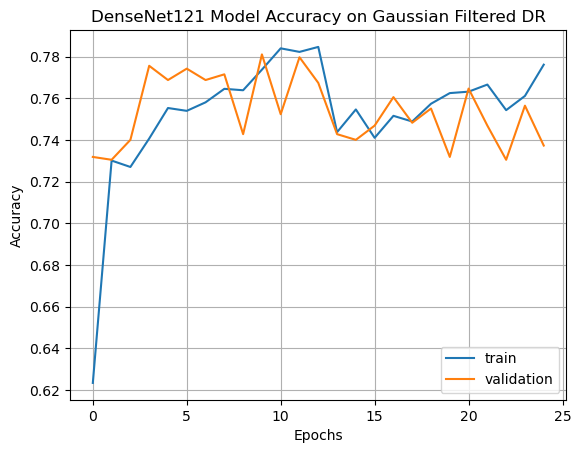

In [28]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet121 Model Accuracy on Gaussian Filtered DR')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [24]:
max_acc = max(graph.history['val_accuracy'])

print('The highest accuracy achieved using DenseNet121 model is',max_acc*100)

The highest accuracy achieved using DenseNet121 model is 78.11217308044434


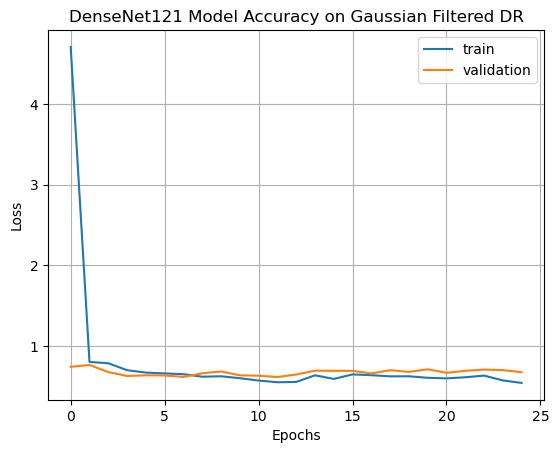

In [30]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet121 Model Accuracy on Gaussian Filtered DR')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()